# Imports

In [ ]:
pip install python-snappy # Dependency of pandavro

     |████████████████████████████████| 61kB 3.2MB/s 


In [ ]:
pip install pandavro # Needed for converting avro into pandas dataframe

     |████████████████████████████████| 2.3MB 9.7MB/s 
  Created wheel for pandavro: filename=pandavro-1.6.0-cp37-none-any.whl size=4557 sha256=fc1aad53389f7292b2c057ac2a313c5e5a7a135427b136da1c0c017fae107e8f
  Stored in directory: /root/.cache/pip/wheels/b4/15/34/1651bfefb11129c79c892b07e96c0e7a1eb79f702b5078b71e
Successfully built pandavro


In [ ]:
pip install tensorflow_text

     |████████████████████████████████| 3.4MB 11.1MB/s 


In [ ]:
pip install langdetect

     |████████████████████████████████| 983kB 9.6MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=b21c642560ea5627d015bddc1bd37227bd4131009f726b44f525fb5b13f3fe8e
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [ ]:
%load_ext tensorboard

In [ ]:
from datetime import datetime
from tqdm import tqdm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import pickle

import tensorflow as tf
import tensorflow_text as text

from langdetect import detect

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Preprocessing dependencies
from pandavro import read_avro
import snappy
import re
from bs4 import BeautifulSoup

import pydot
from networkx.drawing.nx_pydot import graphviz_layout

import networkx as nx
from collections import defaultdict
import json

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# avro to json

In [ ]:
path = "<path to dataframe>"

df = pd.read_pickle(path)
contents = df.content.values
print("Resulting shape and columns: ", df.shape, df.columns)
print("Example of entry: \n", df.iloc[0])

Resulting shape and columns:  (37052, 3) Index(['url', 'content', 'target'], dtype='object')
Example of entry: 
 url        https://www.casaperanzianidontoninobello.com/i...
content    <!DOCTYPE html>\n\n<html dir="ltr" lang="en-gb...
target                                                     1
Name: 0, dtype: object


In [ ]:
labels = df.target.values

In [ ]:
def _traverse_html(_d:BeautifulSoup, _graph:nx.Graph, _counter, _parent=None) -> None:
    for i in _d.contents:
        if i.name is not None: # and i.name != "div"
            try:
                _name_count = _counter.get(i.name)
                if _parent is not None:
                    _graph.add_node(_parent)
                    _graph.add_edge(_parent, i.name if not _name_count else f'{i.name}_{_name_count}')
                if(i.name != "div" and i.name != "span"):
                    _counter[i.name] += 1
                    _traverse_html(i, _graph, _counter, i.name)
                elif _parent is not None:
                    _traverse_html(i, _graph, _counter, _parent)        
            except AttributeError:
                pass

def printGraph(page):
    html = page['content']
    soup = BeautifulSoup(html, features="html.parser")
    for script in soup(["script", "style", "head"]): # Removing content that isn't text
        script.extract()
    fig = plt.gcf()
    fig.canvas.set_window_title(page['url'])
    _full_graph = nx.Graph()
    _traverse_html(soup, _full_graph, defaultdict(int))
    nx.draw(_full_graph, with_labels = True)   
    plt.show()

In [ ]:
tag_whitelist = ['html','body','a','article','blockquote','button','canvas','cite','code','div','embed','footer','form'
                ,'h1','h2','h3','h4','h5','h6','header','i','iframe','img','input','label','li','ol','p','picture','pre','q',
                 'section','source','table','tbody','textarea','title','ul'] 

tag_blacklist = ["script", "style", "head", "svg", "area", "audio", "b", "base", "bdi", "bdo", "br", "caption", "em", "figcaption", "hr", "video"]

tag_dic = defaultdict(int)

i = 0
for tag in tag_whitelist:
  tag_dic[tag] = i
  i+=1

print(tag_dic)

defaultdict(<class 'int'>, {'html': 0, 'body': 1, 'a': 2, 'article': 3, 'blockquote': 4, 'button': 5, 'canvas': 6, 'cite': 7, 'code': 8, 'div': 9, 'embed': 10, 'footer': 11, 'form': 12, 'h1': 13, 'h2': 14, 'h3': 15, 'h4': 16, 'h5': 17, 'h6': 18, 'header': 19, 'i': 20, 'iframe': 21, 'img': 22, 'input': 23, 'label': 24, 'li': 25, 'ol': 26, 'p': 27, 'picture': 28, 'pre': 29, 'q': 30, 'section': 31, 'source': 32, 'table': 33, 'tbody': 34, 'textarea': 35, 'title': 36, 'ul': 37})


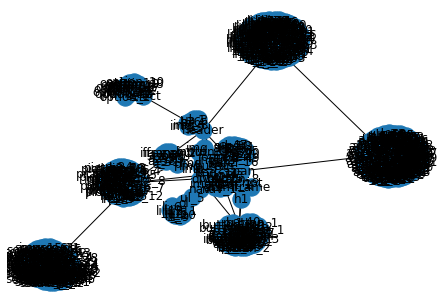

In [ ]:
id = 19
html = df.iloc[id]['content']
soup = BeautifulSoup(html, features="html.parser")
for script in soup(tag_blacklist): # Removing content that isn't text
    script.extract()

graph = nx.Graph()
_traverse_html(soup, graph, defaultdict(int))

fig = plt.gcf()
fig.canvas.set_window_title(df.iloc[id]['url'])
nx.draw(graph, with_labels = True)   
plt.show()
#t = nx.dfs_tree()

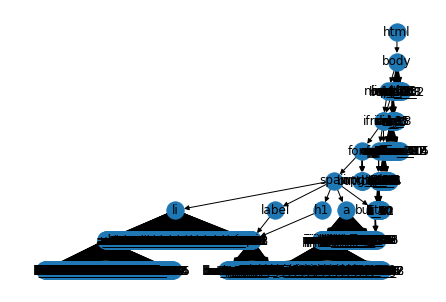

In [ ]:
t = nx.dfs_tree(graph, 'html')
fig = plt.gcf()
#pos = graphviz_layout(t, prog="twopi")
pos = graphviz_layout(t, prog="dot")
#pos = graphviz_layout(t, prog="circo")
nx.draw(t, pos, with_labels = True)   
plt.show()

In [ ]:
def count_tags(tree, tag_dic, features):
  features = [0] * len(tag_dic)

  for node in tree.nodes:
    tag = node.partition("_")[0]
    if(tag_dic.get(tag) == None):
      pass
    else:
      features[tag_dic.get(tag)] += 1
  return features

In [ ]:
def cleanup(raw): # Function that cleans up the html removing tags, scripts and styling
  soup = BeautifulSoup(raw, features = "html.parser")
  for script in soup(["script", "style"]): # Removing content that isn't text
    script.extract()
  # Getting the text, removing blank lines and spaces
  text = soup.get_text()
  lines = (line.strip() for line in text.splitlines())
  clean_lines = (l for l in lines if not(l == "") and len(l.split()) > 1)
  paragraphs = []
  words = []
  for l in clean_lines:
    paragraphs.append(l)
    for word in l.split(" "):
      words.append(word.strip())
  fulltext = ' '.join(word for word in words if word) # It's also possible to concatenate /n
  return paragraphs, fulltext

def count_names(text):
  regex = r'\b([A-Z][a-z]+(?: [A-Z]\.)? [A-Z][a-z]+),'
  re_names = re.compile(regex)
  names = re_names.findall(text)
  return len(set(names))

def count_emails(text):
  regex = r'[a-zA-Z0-9-_]{1,}@[a-zA-Z0-9-_]{1,}.[a-zA-Z]{1,}'
  re_email = re.compile(regex)
  emails = re_email.findall(text)
  return len(set(emails))

def count_phone_numbers(text):
  regex = r'([+]\d{2}\s+)?(\d{10})|(\d{9})|(\d{3}\s+\d{7})|(\d{4}\s+\d{6})'
  re_phone = re.compile(regex)
  numbers = re_phone.findall(text)
  return len(set(numbers))

def count_significant_characters(text):
  #currencies
  dollar_count = text.count('$')
  euro_count = text.count('€')
  pound_count = text.count('£')
  currencies = dollar_count + euro_count + pound_count

  #possibly significant punctuation
  questionmarks = text.count('?')
  esclamationmarks = text.count('!')
  quotes = text.count('"') + text.count('\'')

  copyright = text.count('©')

  return currencies, questionmarks, esclamationmarks, quotes

def count_text_length(text):
  return len(text.split())

def standard_variation_text(texts):
  lengths = []
  for t in texts:
    lengths.append(len(t))
  result = np.std(lengths)
  if result != np.nan:
    return result
  else:
    return 0

def calculate_text_features(soup):
  paragraphs, fulltext = cleanup(soup)
  names = count_names(fulltext)
  emails = count_emails(fulltext)
  sig_characters = count_significant_characters(fulltext)
  numbers = count_phone_numbers(fulltext)
  text_length = count_text_length(fulltext)
  sv = standard_variation_text(paragraphs)
  results = [names,emails, numbers, text_length, sv] + [x for x in sig_characters]
  return results

content = df2.iloc[3]['content']
paragraphs, fulltext = cleanup(content)
print(fulltext)
names = count_names(fulltext)
print("Names found: ", names)
print("Emails found: ", count_emails(fulltext))
print("Phone numbers: ", count_phone_numbers(fulltext))
print("Number of words: ", count_text_length(fulltext))
print("Standard variation: ", standard_variation_text(paragraphs))
print("Significant characters: ", count_significant_characters(fulltext))
t_features = calculate_text_features(content)
print(t_features)

Chi Siamo – Castiel Salta al contenuto CastielTecnologia e Natura Chi Siamo Chi Siamo Ci occupiamo di Tecnologia e Natura. Cosa vuol dire? Vuol dire che applicando la nostra tecnologia sviluppata in anni di prove e di ricerche, riusciamo a sfruttare le potenzialità e la potenza della natura per risolvere piccoli e grandi problemi. Siamo gli inventori ed i produttori del Poseidon, l’unico Solubilizzatore di Calcare esistente al mondo, se vuoi saperne di più vai sul sito dedicato www.anticalcareposeidon.it Abbiamo sviluppato apparecchiature per il trattamento dell’acqua con ozono (il più potente sistema per la potabilizzazione) per fare in modo che chi ha un pozzo artesiano, possa attingere a quel pozzo ed usarne l’acqua in modo tranquillo e senza pericoli, nonostante ci possano essere batteri o virus al suo interno. Abbiamo sviluppato una tecnologia per rimuovere odori e muffe dai locali (piccoli o grandi che siano) sempre tramite l’utilizzo dell’Ozono per bonificare gli ambienti. Da qu

In [ ]:
def count_socials(soup):
  links = []
  for link in soup.findAll('a'):
      t = link.get('href')
      if(t is not None and len(t) > 3):
        links.append(t)
  twitter_pattern = "^https?:\/\/www\.facebook\.com.*"
  linkedin_pattern = "^https?:\/\/www\.linkedin\.com.*"
  facebook_pattern = "^https?:\/\/www\.twitter\.com.*|^https?:\/.twitter\.com.*"
  re_twitter = re.compile(twitter_pattern)
  re_linkedin = re.compile(linkedin_pattern)
  re_facebook = re.compile(facebook_pattern)
  facebook = 0
  instagram = 0
  twitter = 0
  linkedin = 0
  for link in links:
    if(re_twitter.search(link) is not None):
      twitter += 1
    elif(re_linkedin.search(link) is not None):
      linkedin += 1
    elif(re_facebook.search(link) is not None):
      facebook += 1
  return [facebook, twitter, linkedin]

id = 7
content = df2.iloc[id]['content']
s = BeautifulSoup(content, features="html.parser")
socials = count_socials(s)
print(socials)

[0, 2, 0]


In [ ]:
embeddings = []
index = 0
for row in tqdm(df2.iterrows(), total = df2.shape[0]):
  html = row[1]['content']
  soup = BeautifulSoup(html, features="html.parser")
  for script in soup(tag_blacklist): # Removing content that isn't text
      script.extract()

  graph = nx.Graph()
  _traverse_html(soup, graph, defaultdict(int))
  nodes = list(graph.nodes)
  if(len(nodes) > 3):
    t = nx.dfs_tree(graph, nodes[0])
    node_features = count_tags(t, tag_dic, [0]*len(tag_dic))

    social_features = count_socials(soup)

    t_features = calculate_text_features(html)

    features = node_features + social_features + t_features
    embeddings.append(features)
  else:
    labels = np.delete(labels, index)
    index -= 1
  index += 1

embeddings = pd.DataFrame.from_records(embeddings)
print("Embeddings:")
print(embeddings.head())

In [ ]:
embeddings.to_pickle("<path to embeddings>")

In [ ]:
embeddings = pd.read_pickle("<path to embeddings>")

In [ ]:
# Create inverse dictionary on the features

inv = {v: k for k, v in tag_dic.items()}
dic_size = len(inv)
inv[dic_size] = "facebook"
dic_size+=1
inv[dic_size] = "twitter"
dic_size+=1
inv[dic_size] = "linkedin"
dic_size+=1
inv[dic_size] = "names"
dic_size+=1
inv[dic_size] = "emails"
dic_size+=1
inv[dic_size] = "phone"
dic_size+=1
inv[dic_size] = "words"
dic_size+=1
inv[dic_size] = "st_var"
dic_size+=1
inv[dic_size] = "currencies"
dic_size+=1
inv[dic_size] = "questionmarks"
dic_size+=1
inv[dic_size] = "esclamationmarks"
dic_size+=1
inv[dic_size] = "quotes"

In [ ]:
embeddings = embeddings.rename(columns=
          {0: inv[0], 1: inv[1], 2: inv[2], 3: inv[3], 4: inv[4],5: inv[5], 6: inv[6],7: inv[7], 8: inv[8],9: inv[9], 10: inv[10],
           11: inv[11], 12: inv[12],13: inv[13], 14:inv[14], 15: inv[15], 16: inv[16], 17: inv[17], 18: inv[18], 19: inv[19], 20: inv[20],
           21: inv[21], 22: inv[22],23: inv[23], 24: inv[24], 25: inv[25], 26: inv[26], 27: inv[27], 28: inv[28], 29: inv[29], 30: inv[30],
           31: inv[31], 32: inv[32],33: inv[33], 34: inv[34], 35: inv[35], 36: inv[36], 37: inv[37], 38: inv[38]})

print(embeddings)

# Dataset preparation

In [ ]:
def shuffle_arrays(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
np.random.seed(seed=45)
mask = np.random.rand(embeddings.shape[0]) < 0.9
X_train = embeddings[mask]
Y_train = labels[mask]
X_test = embeddings[~mask]
Y_test = labels[~mask]

X_train, Y_train = sklearn.utils.shuffle(X_train, Y_train)
X_test, Y_test = sklearn.utils.shuffle(X_test, Y_test)

print("Created training set of shape: ", X_train.shape)
print("Created testing set of shape: ", X_test.shape)

Created training set of shape:  (31853, 50)
Created testing set of shape:  (3508, 50)


# XGBoost

In [ ]:
from collections import Counter

In [ ]:
Counter(Y_train)

Counter({0: 15279, 1: 16574})

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
sklearn.metrics.plot_confusion_matrix(xgb, X_test, Y_test, values_format='d', display_labels = ["No team", "Team"])

In [ ]:
# Hyperparameters optimization (round 1)
param_grid = {
    'max_depth': [3,4,5],
    'learning_rate': [0.7, 0.5, 0.1, 0.01],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0, 20.0],
}

optimal_params = sklearn.model_selection.GridSearchCV(
    estimator=xgb.XGBClassifier(    
      objective='binary:logistic',
      seed = 42,
      subsample = 0.9,
      colsample_bytree = 0.5),
    param_grid = param_grid,
    scoring = 'roc_auc',
    verbose = 2,
    n_jobs = 10,
    cv = 3
)

optimal_params.fit(
    X_train,
    Y_train,
    early_stopping_rounds = 25,
    eval_metric = 'auc',
    eval_set = [(X_test, Y_test)],
    verbose = False)

print("\nThe best parameters are::\n")
print(optimal_params.best_params_)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   49.7s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  4.9min
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed: 11.2min
[Parallel(n_jobs=10)]: Done 432 out of 432 | elapsed: 14.0min finished



The best parameters are::

{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 0}


In [ ]:
xgb_model = xgb.XGBClassifier(
    seed = 33,
    n_estimators = 10000,
    objective = 'binary:logistic',
    gamma = 0.25,
    learn_rate = 0.1,
    max_depth = 7,
    reg_lambda = 0,
)

xgb_model.fit(X_train,Y_train, early_stopping_rounds=50, eval_metric='aucpr', eval_set=[(X_test, Y_test)], verbose = 1)

[0]	validation_0-aucpr:0.791006
Will train until validation_0-aucpr hasn't improved in 50 rounds.
[1]	validation_0-aucpr:0.808655
[2]	validation_0-aucpr:0.823353
[3]	validation_0-aucpr:0.826804
[4]	validation_0-aucpr:0.828488
[5]	validation_0-aucpr:0.832455
[6]	validation_0-aucpr:0.83462
[7]	validation_0-aucpr:0.837088
[8]	validation_0-aucpr:0.838058
[9]	validation_0-aucpr:0.838194
[10]	validation_0-aucpr:0.839929
[11]	validation_0-aucpr:0.842496
[12]	validation_0-aucpr:0.844113
[13]	validation_0-aucpr:0.845019
[14]	validation_0-aucpr:0.846733
[15]	validation_0-aucpr:0.848511
[16]	validation_0-aucpr:0.850205
[17]	validation_0-aucpr:0.850731
[18]	validation_0-aucpr:0.850139
[19]	validation_0-aucpr:0.85119
[20]	validation_0-aucpr:0.852443
[21]	validation_0-aucpr:0.852906
[22]	validation_0-aucpr:0.858119
[23]	validation_0-aucpr:0.858711
[24]	validation_0-aucpr:0.860446
[25]	validation_0-aucpr:0.861213
[26]	validation_0-aucpr:0.861753
[27]	validation_0-aucpr:0.862225
[28]	validation_0-aucp

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.25,
              learn_rate=0.1, learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=10000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=33,
              silent=None, subsample=1, verbosity=1)

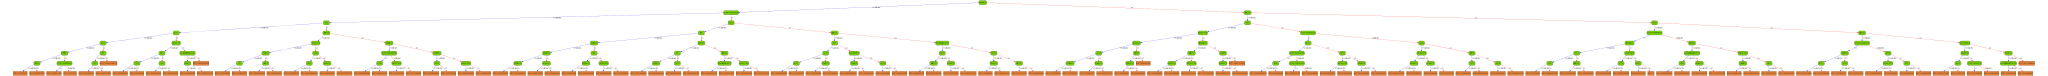

In [ ]:
node_params = {
    'shape': 'box',
    'style': 'filled, rounded',
    'fillcolor': '#78cbe'
}
leaf_params = {
    'shape': 'box',
    'style': 'filled',
    'fillcolor': '#e48038'
}

xgb.to_graphviz(xgb_model, num_trees = 1, size = "30,30", condition_node_params=node_params, leaf_node_params=leaf_params)

In [ ]:
preds = xgb_model.predict(X_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(Y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.424788


              precision    recall  f1-score   support

     No team       0.83      0.78      0.80      1667
        Team       0.81      0.86      0.83      1841

    accuracy                           0.82      3508
   macro avg       0.82      0.82      0.82      3508
weighted avg       0.82      0.82      0.82      3508



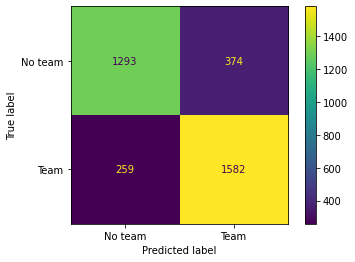

In [ ]:
cm = confusion_matrix(Y_test,preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=['No team','Team'])
cmd.plot(values_format = 'd')

print(classification_report(Y_test, preds, target_names=['No team', 'Team']))

In [ ]:
importance = xgb_model.feature_importances_
feature_imp = []
for i in range(len(importance)):
  feature_imp.append([inv[i], importance[i]])

array = np.asarray(feature_imp)
sorted_features = np.flip(array[np.argsort(array[:, 1])], axis=0)
print(sorted_features)

[['phone' '0.1106815']
 ['img' '0.044171173']
 ['li' '0.037886523']
 ['h2' '0.03478356']
 ['article' '0.03396763']
 ['currencies' '0.031103157']
 ['h1' '0.028260214']
 ['code' '0.026212009']
 ['esclamationmarks' '0.022356609']
 ['header' '0.021303918']
 ['tfoot' '0.021227766']
 ['st_var' '0.02033548']
 ['questionmarks' '0.018841127']
 ['linkedin' '0.018750569']
 ['facebook' '0.018735334']
 ['iframe' '0.018020475']
 ['picture' '0.016578589']
 ['twitter' '0.016139288']
 ['h3' '0.016083617']
 ['aside' '0.015873132']
 ['words' '0.015573814']
 ['th' '0.014320401']
 ['table' '0.014162046']
 ['ol' '0.014053697']
 ['embed' '0.013986519']
 ['footer' '0.013391527']
 ['textarea' '0.013374782']
 ['blockquote' '0.013185752']
 ['a' '0.013131455']
 ['social_counter' '0.012982413']
 ['button' '0.012853363']
 ['tbody' '0.01282878']
 ['p' '0.012767671']
 ['i' '0.012673914']
 ['html' '0.01259521']
 ['section' '0.012523863']
 ['td' '0.012444351']
 ['emails' '0.012254683']
 ['source' '0.012252792']
 ['quot

# Feature selection

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

In [ ]:
importance = xgb_model.feature_importances_
feature_imp = []
for i in range(len(importance)):
  feature_imp.append([inv[i], importance[i]])

array = np.asarray(feature_imp)
sorted_features = np.flip(array[np.argsort(array[:, 1])], axis=0)
print(sorted_features)

[['phone' '0.12995431']
 ['img' '0.05046054']
 ['li' '0.04216378']
 ['h2' '0.03861602']
 ['article' '0.03643275']
 ['currencies' '0.03233438']
 ['code' '0.03088368']
 ['h1' '0.03060959']
 ['esclamationmarks' '0.024110181']
 ['header' '0.023366872']
 ['st_var' '0.023331575']
 ['iframe' '0.021734871']
 ['linkedin' '0.021203306']
 ['facebook' '0.02045166']
 ['table' '0.020314446']
 ['twitter' '0.018891321']
 ['questionmarks' '0.018823495']
 ['source' '0.017941415']
 ['h3' '0.01773633']
 ['words' '0.017680518']
 ['footer' '0.01621389']
 ['embed' '0.015716216']
 ['ol' '0.0153978625']
 ['a' '0.014985927']
 ['p' '0.014947886']
 ['textarea' '0.01492155']
 ['i' '0.014424882']
 ['button' '0.014080496']
 ['section' '0.013879959']
 ['html' '0.013879913']
 ['emails' '0.013772948']
 ['picture' '0.013528842']
 ['quotes' '0.013113276']
 ['ul' '0.013093205']
 ['tbody' '0.012895504']
 ['h4' '0.012873752']
 ['blockquote' '0.012841634']
 ['h5' '0.012399437']
 ['label' '0.012277192']
 ['h6' '0.0122033935']

In [ ]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [ ]:
thresholds = np.sort(xgb_model.feature_importances_)
for thresh in thresholds:
  selection = SelectFromModel(xgb_model, threshold = thresh, prefit=True)
  select_X_train = selection.transform(X_train)
  selection_model = xgb.XGBClassifier()
  selection_model.fit(select_X_train, Y_train)
  select_X_test = selection.transform(X_test)
  predictions = selection_model.predict(select_X_test)
  accuracy = accuracy_score(Y_test, predictions)
  print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.004, n=50, Accuracy: 79.90%
Thresh=0.006, n=49, Accuracy: 79.90%
Thresh=0.006, n=48, Accuracy: 79.90%
Thresh=0.007, n=47, Accuracy: 79.90%
Thresh=0.008, n=46, Accuracy: 79.90%
Thresh=0.009, n=45, Accuracy: 79.90%
Thresh=0.010, n=44, Accuracy: 79.90%
Thresh=0.011, n=43, Accuracy: 79.90%
Thresh=0.012, n=42, Accuracy: 79.76%
Thresh=0.012, n=41, Accuracy: 79.76%
Thresh=0.012, n=40, Accuracy: 79.76%
Thresh=0.012, n=39, Accuracy: 79.76%
Thresh=0.012, n=38, Accuracy: 79.76%
Thresh=0.013, n=37, Accuracy: 79.73%
Thresh=0.013, n=36, Accuracy: 79.73%
Thresh=0.013, n=35, Accuracy: 79.53%
Thresh=0.013, n=34, Accuracy: 79.53%
Thresh=0.013, n=33, Accuracy: 80.05%
Thresh=0.014, n=32, Accuracy: 79.59%
Thresh=0.014, n=31, Accuracy: 79.62%
Thresh=0.014, n=30, Accuracy: 79.59%
Thresh=0.014, n=29, Accuracy: 79.70%
Thresh=0.014, n=28, Accuracy: 79.42%
Thresh=0.014, n=27, Accuracy: 79.25%
Thresh=0.015, n=26, Accuracy: 79.45%
Thresh=0.015, n=25, Accuracy: 79.22%
Thresh=0.015, n=24, Accuracy: 79.05%
T

In [ ]:
# Model with less, more important features

selection = SelectFromModel(xgb_model, threshold = 0.012, prefit=True)
select_X_train = selection.transform(X_train)
selection_model = xgb.XGBClassifier()
selection_model.fit(select_X_train, Y_train)
select_X_test = selection.transform(X_test)
predictions = selection_model.predict(select_X_test)
accuracy = accuracy_score(Y_test, predictions)

features_length = len(selection_model.get_booster().feature_names)
print("Features left:")
print(sorted_features[:features_length])

Features left:
[['phone' '0.12995431']
 ['img' '0.05046054']
 ['li' '0.04216378']
 ['h2' '0.03861602']
 ['article' '0.03643275']
 ['currencies' '0.03233438']
 ['code' '0.03088368']
 ['h1' '0.03060959']
 ['esclamationmarks' '0.024110181']
 ['header' '0.023366872']
 ['st_var' '0.023331575']
 ['iframe' '0.021734871']
 ['linkedin' '0.021203306']
 ['facebook' '0.02045166']
 ['table' '0.020314446']
 ['twitter' '0.018891321']
 ['questionmarks' '0.018823495']
 ['source' '0.017941415']
 ['h3' '0.01773633']
 ['words' '0.017680518']
 ['footer' '0.01621389']
 ['embed' '0.015716216']
 ['ol' '0.0153978625']
 ['a' '0.014985927']
 ['p' '0.014947886']
 ['textarea' '0.01492155']
 ['i' '0.014424882']
 ['button' '0.014080496']
 ['section' '0.013879959']
 ['html' '0.013879913']
 ['emails' '0.013772948']
 ['picture' '0.013528842']
 ['quotes' '0.013113276']
 ['ul' '0.013093205']
 ['tbody' '0.012895504']
 ['h4' '0.012873752']
 ['blockquote' '0.012841634']
 ['h5' '0.012399437']
 ['label' '0.012277192']
 ['h6' 

In [ ]:
selection_model.seed = 33
selection_model.n_estimators = 10000
selection_model.objective = 'binary:logistic'
selection_model.gamma = 0.25
selection_model.learn_rate = 0.1
selection_model.max_depth = 7
selection_model.reg_lambda = 0

selection_model.fit(select_X_train,Y_train, early_stopping_rounds=50, eval_metric='aucpr', eval_set=[(select_X_test, Y_test)], verbose = 1)

[0]	validation_0-aucpr:0.790998
Will train until validation_0-aucpr hasn't improved in 50 rounds.
[1]	validation_0-aucpr:0.808389
[2]	validation_0-aucpr:0.823572
[3]	validation_0-aucpr:0.827035
[4]	validation_0-aucpr:0.828463
[5]	validation_0-aucpr:0.832588
[6]	validation_0-aucpr:0.834712
[7]	validation_0-aucpr:0.837431
[8]	validation_0-aucpr:0.838541
[9]	validation_0-aucpr:0.838645
[10]	validation_0-aucpr:0.840416
[11]	validation_0-aucpr:0.842909
[12]	validation_0-aucpr:0.845127
[13]	validation_0-aucpr:0.84543
[14]	validation_0-aucpr:0.845652
[15]	validation_0-aucpr:0.849143
[16]	validation_0-aucpr:0.851134
[17]	validation_0-aucpr:0.852584
[18]	validation_0-aucpr:0.853613
[19]	validation_0-aucpr:0.853815
[20]	validation_0-aucpr:0.855222
[21]	validation_0-aucpr:0.855234
[22]	validation_0-aucpr:0.856823
[23]	validation_0-aucpr:0.859076
[24]	validation_0-aucpr:0.859707
[25]	validation_0-aucpr:0.860489
[26]	validation_0-aucpr:0.860487
[27]	validation_0-aucpr:0.860634
[28]	validation_0-auc

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.25,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=10000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=33,
              silent=None, subsample=1, verbosity=1)

In [ ]:
preds = selection_model.predict(select_X_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(Y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.426462


              precision    recall  f1-score   support

     No team       0.83      0.77      0.80      1667
        Team       0.81      0.86      0.83      1841

    accuracy                           0.82      3508
   macro avg       0.82      0.82      0.82      3508
weighted avg       0.82      0.82      0.82      3508



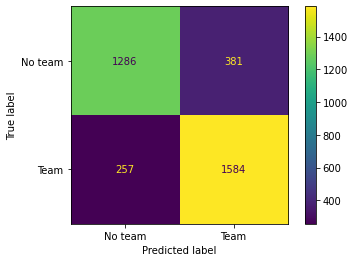

In [ ]:
cm = confusion_matrix(Y_test,preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=['No team','Team'])
cmd.plot(values_format = 'd')

print(classification_report(Y_test, preds, target_names=['No team', 'Team']))

# Shap

In [ ]:
pip install shap

In [ ]:
import shap

In [ ]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train)

In [ ]:
# Prediction to analyse

page = 12

print("Explaining page: ", df2.iloc[page]['url'])
print("Target: ", df2.iloc[page]['target'])

Explaining page:  https://www.centroesteticosuavis.it/chi-siamo/
Target:  1


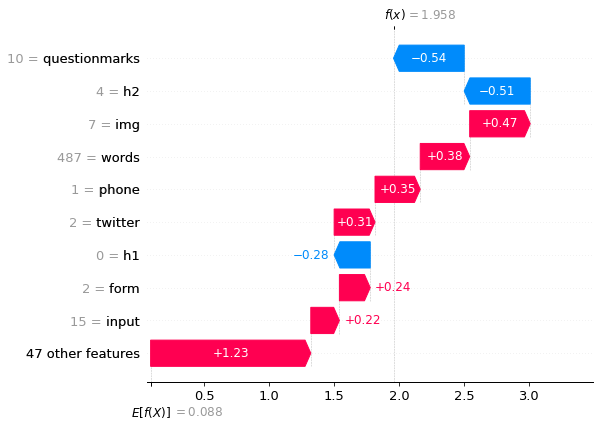

In [ ]:
shap.plots.waterfall(shap_values[page])

In [ ]:
shap.initjs()
shap.plots.force(shap_values[page])

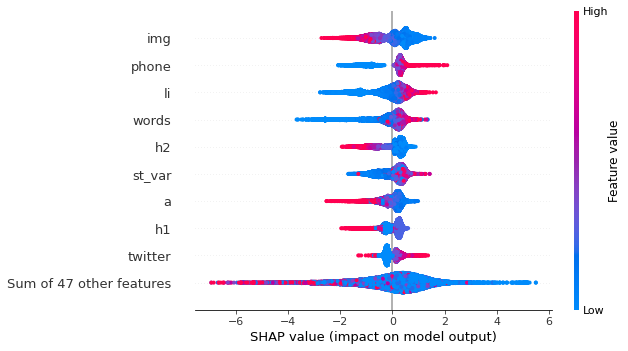

In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

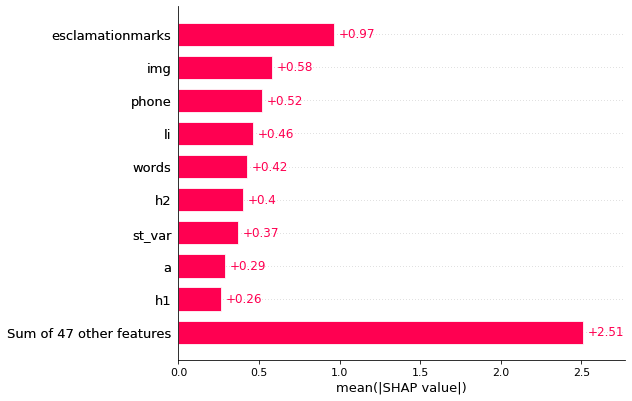

In [ ]:
shap.plots.bar(shap_values)

# NN

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
def create_model(denseOutput = 32, dropout = 0.1, act = "relu", lr = 0.01):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.Input(shape = (42,)))
  model.add(tf.keras.layers.Dense(denseOutput, activation = act))
  model.add(tf.keras.layers.Dropout(dropout))
  model.add(tf.keras.layers.Dense(1, activation = "sigmoid"))

  opt = tf.keras.optimizers.Adam(lr)
  model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
  return model

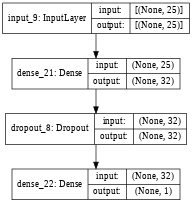

In [ ]:
model = create_model()
tf.keras.utils.plot_model(model, show_shapes=True, dpi = 48)

In [ ]:
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=64, verbose=0)
denseOutput = [8, 16, 32]
dropout = [0.05, 0.1, 0.2]
act = ["relu","tanh"]
lr = [0.01, 0.001]
param_grid = dict(denseOutput=denseOutput, dropout=dropout, act=act, lr=lr)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose = 10)
grid_result = grid.fit(X_train, Y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
def create_tuned_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.Input(shape = (25,)))
  model.add(tf.keras.layers.Dense(16, activation = 'tanh'))
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.Dense(1, activation = "sigmoid"))

  opt = tf.keras.optimizers.Adam(0.001)
  model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
  return model

In [ ]:
# define the grid search parameters
model = KerasClassifier(build_fn=create_model, verbose=0)
batch_size = [8, 16, 32, 64, 128, 256]
epochs = [10, 20, 35, 50]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose = 10)
grid_result = grid.fit(X_train, Y_train)

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Training parameters

tuned_model = create_tuned_model()

epochs = 100
batch_size = 256
eval_batch_size = batch_size

#Callbacks

tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/{}".format(datetime.now()))
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( 
    monitor="val_loss",
    factor=0.3,
    patience=1,
    verbose=0,
    mode="auto",
)

tuned_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 16)                416       
_________________________________________________________________
dropout_12 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 17        
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________


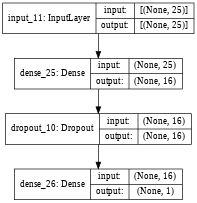

In [ ]:
tf.keras.utils.plot_model(tuned_model, show_shapes=True, dpi = 48)

In [ ]:
X_train['st_var'] = X_train['st_var'].fillna(0)
X_test['st_var'] = X_test['st_var'].fillna(0)

In [ ]:
# Training

history = tuned_model.fit(
    x = X_train,
    y = Y_train,
    epochs = 100,
    batch_size = batch_size,
    validation_data = (X_test, Y_test),
    verbose = 1,
    #class_weight=weights,
    #callbacks=[reduce_lr, tensorboard]
)

Epoch 1/100
125/125 [==============================] - 1s 4ms/step - loss: 0.9801 - accuracy: 0.4697 - val_loss: 0.6689 - val_accuracy: 0.6040
Epoch 2/100
125/125 [==============================] - 0s 2ms/step - loss: 0.6846 - accuracy: 0.5750 - val_loss: 0.6361 - val_accuracy: 0.6676
Epoch 3/100
125/125 [==============================] - 0s 2ms/step - loss: 0.6508 - accuracy: 0.6254 - val_loss: 0.5906 - val_accuracy: 0.6978
Epoch 4/100
125/125 [==============================] - 0s 2ms/step - loss: 0.6097 - accuracy: 0.6696 - val_loss: 0.5645 - val_accuracy: 0.7238
Epoch 5/100
125/125 [==============================] - 0s 2ms/step - loss: 0.5804 - accuracy: 0.7009 - val_loss: 0.5482 - val_accuracy: 0.7172
Epoch 6/100
125/125 [==============================] - 0s 2ms/step - loss: 0.5631 - accuracy: 0.7171 - val_loss: 0.5388 - val_accuracy: 0.7434
Epoch 7/100
125/125 [==============================] - 0s 2ms/step - loss: 0.5559 - accuracy: 0.7236 - val_loss: 0.5417 - val_accuracy: 0.7397

In [ ]:
loss, accuracy = tuned_model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.3f}".format(accuracy))
loss, accuracy = tuned_model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.3f}".format(accuracy))

Training Accuracy: 0.772
Testing Accuracy:  0.777


In [ ]:
def argmax(results):
  r = []
  for result in results:
    if(result > 0.5):
      r.append(1)
    else:
      r.append(0)
  return r

[[0.8334256 ]
 [0.89073884]
 [0.11929646]
 ...
 [0.89141184]
 [0.78272736]
 [0.05401239]]
[1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 

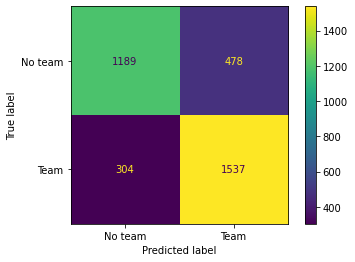

In [ ]:
preds = tuned_model.predict(X_test)
print(preds)
argmax_y_pred = argmax(preds)
print(argmax_y_pred)
cm = confusion_matrix(Y_test,argmax_y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['No team','Team'])
cmd.plot(values_format = 'd')

print(classification_report(Y_test, argmax_y_pred, target_names=['No team', 'Team']))